In [1]:
import os, subprocess, msprime, pyslim, tskit
import numpy as np 
import matplotlib.pyplot as plt

This notebook briefly introduces the powerful `recapitate` functionality of SLiM/msprime.

Example 4 of:

https://onlinelibrary.wiley.com/doi/full/10.1111/1755-0998.12968

Galloway, J., Messer, P. W., Haller, B. C., Kelleher, J., & Ralph, P. L. (2018). Tree-sequence recording in SLiM opens new horizons for forward-time simulation of whole genomes. Molecular Ecology Resources, (November 2018), 552–566. https://doi.org/10.1111/1755-0998.12968

This SLiM script is doing the following:

 - simulating a tree sequence 
 - holding a whole population, size 100 000
 - containing exactly one v strongly selected locus halfway through the simulated sequence
 
> Simulating the neutral burn‐in period in SLiM instead, with neutral mutations occurring at a rate of μ =10−7, would take an esti- mated 114.7 hr.'

In [2]:
slim_script = '''
initialize() { 
    initializeTreeSeq(); 
    initializeMutationRate(0); 
    initializeMutationType("m2", 0.5, "f", 1); // selection  coeff = 0.9
    m2.convertToSubstitution = F; 
    initializeGenomicElementType("g1", m2, 1); 
    initializeGenomicElement(g1, 0, 1e6 - 1); 
    initializeRecombinationRate(3e-10);
} 

1 late() { 
    sim.addSubpop("p1", 100000);
}

100 late() { 
    sample(p1.genomes, 1).addNewDrawnMutation(m2, 5e5);
}

100:10000 late() { 
    mut = sim.mutationsOfType(m2); 
    if (mut.size() != 1) 
        stop(sim.generation + ": LOST");
    else if (sum(sim.mutationFrequencies(NULL, mut)) == 1.0)
    { 
        sim.treeSeqOutput("ex4_TS_decap.trees"); 
        sim.simulationFinished();
    } 
}
'''

slim_file = open("slim_script.slim", "w")
slim_file.writelines(slim_script)
slim_file.close()

In [3]:
slim_run = os.system("slim slim_script.slim")

And then run this in the terminal:
```
slim slim_script.slim 
```
After some time you should have a SLiM-generated tree-sequence file called `ex4_TS_decap.trees`:

In [4]:
# Calculate tree heights. Should be able to use mrca though??
def tree_heights(ts):
    heights = np.zeros(ts.num_trees + 1) 
    for tree in ts.trees(): 
        if tree.num_roots > 1: # not fully coalesced
            heights[tree.index] = ts.slim_generation
        else:
            root_children = tree.children(tree.root) 
            real_root = tree.root if len(root_children) > 1 else root_children[0] 
            heights[tree.index] = tree.time(real_root)
            heights[-1] = heights[-2] # repeat the last entry for plotting with step 
    return heights

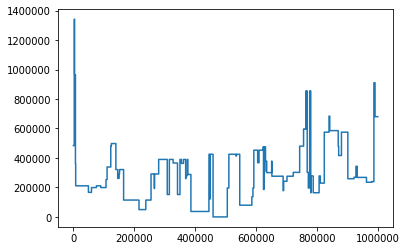

In [5]:

# Run the SLiM model and load the resulting .trees file 
# subprocess.check_output(["slim", "-m", "-s", "2", "ex4_TS.slim"]) 
ts = pyslim.load("ex4_TS_decap.trees")
# no simplify!

# Recapitate
recap = ts.recapitate(recombination_rate=3e-10, Ne=1e5, random_seed=1) 
recap.dump("ex4_TS_recap-1.trees")
# Plot tree heights after recapitation 
breakpoints = list(recap.breakpoints()) 
heights = tree_heights(recap) 
plt.step(breakpoints, heights, where='post') 
plt.show()

In [6]:
# # CURRENTLY DOESN'T WORK
# # Run the SLiM model and load the resulting .trees file 
# # subprocess.check_output(["slim", "-m", "-s", "2", "ex4_TS.slim"]) 
# ts = pyslim.load("ex4_TS_decap.trees")
# # no simplify!

# # Recapitate
# recap = ts.recapitate(recombination_rate=3e-10, Ne=1e5, random_seed=1) 
# recap.dump("ex4_TS_recap.trees")
# # Plot tree heights after recapitation 
# breakpoints = list(recap.breakpoints()) 
# heights = np.zeros(ts.num_trees)
# for tree in recap.trees():
#     root_node = tree.root
#     root_time = ts.node(root_node).time
#     heights[tree.index] = time
# plt.step(breakpoints, heights, where='post') 
# plt.show()